## Installing libraries that are not in collab

In [164]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [165]:
ls

intents.json  runs/  sample_data/  test_data.csv  train_data.csv


## Import Libraries
Importing the libraries that are required to perform operations on the dataset.

In [166]:
import json
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = torch.device("cpu")

## Data preprocessing
Doing required processing of data.

In [167]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [168]:
df_train.head()

,text,intent
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [169]:
df_test.head()

,text,intent
0,hello there,greeting
1,How is everything,greeting
2,How’s everything going,greeting
3,Good to see you,greeting
4,How you doing,greeting


In [170]:
df_train["intent"].value_counts()

course            34
fees              32
hostel            22
fest              21
scholarship       20
faculty           20
creator           18
hours             17
goodbye           17
location          16
name              15
number            15
document          13
salutaion         12
library           12
admission         12
event             11
infrastructure    11
greeting          10
canteen           10
student portal     9
college intake     9
uniform            9
swear              9
placement          8
ragging            8
faculty portal     7
sports             7
transport          7
principal          7
syllabus           7
task               6
facilities         5
menu               5
csehod             4
hod                3
random             3
other              1
Name: intent, dtype: int64

In [171]:
df_test["intent"].value_counts()

greeting    5
goodbye     3
creator     3
name        1
Name: intent, dtype: int64

In [172]:
# Converting the labels into encodings

le = LabelEncoder()
df_test['intent'] = le.fit_transform(df_test['intent'])
df_train['intent'] = le.fit_transform(df_train['intent'])

In [173]:
# check class distribution
df_train['intent'].value_counts(normalize = True)

3     0.075221
11    0.070796
16    0.048673
12    0.046460
30    0.044248
9     0.044248
4     0.039823
17    0.037611
13    0.037611
20    0.035398
22    0.033186
23    0.033186
6     0.028761
29    0.026549
19    0.026549
0     0.026549
7     0.024336
18    0.024336
14    0.022124
1     0.022124
32    0.019912
2     0.019912
37    0.019912
33    0.019912
25    0.017699
27    0.017699
10    0.015487
31    0.015487
36    0.015487
26    0.015487
34    0.015487
35    0.013274
8     0.011062
21    0.011062
5     0.008850
15    0.006637
28    0.006637
24    0.002212
Name: intent, dtype: float64

In [174]:
# check class distribution
df_test['intent'].value_counts(normalize = True)

2    0.416667
1    0.250000
0    0.250000
3    0.083333
Name: intent, dtype: float64

In [175]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df_train["text"], df_train["intent"]
test_text, test_labels = df_test["text"], df_test["intent"]


## 1) Using DistilBert

In [176]:
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

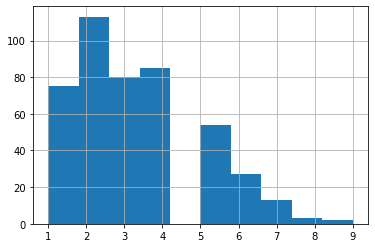

In [177]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

# Based on the histogram we are selecting the max len as 9
max_seq_len = 9

In [178]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)
tokens_test = tokenizer(
    test_text.tolist(),
    max_length = max_seq_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

In [179]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [180]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Setting Up models parameters

In [181]:
# Define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training and testing
train_sampler = RandomSampler(train_data)
test_sampler = RandomSampler(test_data)

# DataLoader for train set and test set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Building our Lucy Model
To build lucy we are going to use pretrained Model and our own model.

### 1) DistilBert

In [182]:
# Import the DistilBert pretrained model
dis_bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Architecture of Lucy Model

In [183]:
class Lucy(nn.Module):
  def __init__(self, pretrained_model):      
       super(Lucy, self).__init__()       
       self.pretrained_model = pretrained_model 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()     

       # dense layer       
       self.fc1 = nn.Linear(768,512)       
       self.fc2 = nn.Linear(512,256)       
       self.fc3 = nn.Linear(256,38)    

       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)      
      
  #define the forward pass
  def forward(self, sent_id, mask):      
      #pass the inputs to the model  
      cls_hs = self.pretrained_model(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)      

      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)     
      return x

In [184]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.

for param in dis_bert.parameters():
      param.requires_grad = False

model = Lucy(dis_bert)

# push the model to GPU
model = model.to(device)


summary(model)

Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           9,766
├─LogSoftmax: 1-7                                       --
Total 

In [185]:
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [186]:
#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[ 0.99122807  1.18947368  1.32163743  0.3498452   0.66081871  2.97368421
  0.91497976  1.08133971  2.37894737  0.59473684  1.69924812  0.37171053
  0.56641604  0.6996904   1.18947368  3.96491228  0.54066986  0.6996904
  1.08133971  0.99122807  0.74342105  2.37894737  0.79298246  0.79298246
 11.89473684  1.48684211  1.69924812  1.48684211  3.96491228  0.99122807
  0.59473684  1.69924812  1.32163743  1.32163743  1.69924812  1.98245614
  1.69924812  1.32163743]


In [187]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [188]:
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [189]:
# empty lists to store training and validation loss of each epoch
train_losses=[]

# number of training epochs
epochs = 200

# We can also use learning rate scheduler to achieve better results
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [190]:
# function to train the model
def train(dataloader):
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]

   # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clear calculated gradients
    optimizer.zero_grad()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
  return avg_loss, total_preds
  
 

In [191]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train(train_dataloader)
    
    # append training and validation loss
    train_losses.append(train_loss)   
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200

Training Loss: 3.661

 Epoch 2 / 200

Training Loss: 3.568

 Epoch 3 / 200

Training Loss: 3.394

 Epoch 4 / 200

Training Loss: 3.164

 Epoch 5 / 200

Training Loss: 2.973

 Epoch 6 / 200

Training Loss: 2.749

 Epoch 7 / 200

Training Loss: 2.462

 Epoch 8 / 200

Training Loss: 2.204

 Epoch 9 / 200

Training Loss: 1.979

 Epoch 10 / 200

Training Loss: 1.804

 Epoch 11 / 200

Training Loss: 1.600

 Epoch 12 / 200

Training Loss: 1.421

 Epoch 13 / 200

Training Loss: 1.312

 Epoch 14 / 200

Training Loss: 1.257

 Epoch 15 / 200

Training Loss: 1.067

 Epoch 16 / 200

Training Loss: 1.036

 Epoch 17 / 200

Training Loss: 0.909

 Epoch 18 / 200

Training Loss: 0.806

 Epoch 19 / 200

Training Loss: 0.745

 Epoch 20 / 200

Training Loss: 0.687

 Epoch 21 / 200

Training Loss: 0.614

 Epoch 22 / 200

Training Loss: 0.609

 Epoch 23 / 200

Training Loss: 0.560

 Epoch 24 / 200

Training Loss: 0.476

 Epoch 25 / 200

Training Loss: 0.495

 Epoch 26 / 200

Training Loss: 0

## Saving the Lucy model

In [192]:
PATH = "lucy_distilbert.pth"
torch.save(model.state_dict(), PATH)

## Testing the Lucy

In [193]:
# TODO: Test LUCY on test dataset and evaluate different evalutaion metrics (eg: Confusion matrix, f1-score, etc)

In [194]:
# TODO: Generate report

## Inference

In [195]:
def get_prediction(str):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 model.eval()
 
 tokens_test_data = tokenizer(
                  test_text,
                  max_length = max_seq_len,
                  padding="max_length",
                  truncation=True,
                  return_token_type_ids=False
                ) 
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
   
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print("Intent Identified: ", le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]


In [196]:
def get_response(intents_data, message): 
  intent = get_prediction(message)
  for i in intents_data['intents']: 
     if i["tag"] == intent:
       result = random.choice(i["responses"])
       break
  print(f"Response : {result}")
  return "Intent: "+ intent + "\n" + "Response: " + result

In [197]:
f = open('intents.json')
data = json.load(f)


get_response(data,"Where is Nec?")

Intent Identified:  location
Response : Changunarayan, Bhaktapur, Nepal. For more details visit <a target="_blank" href="https://nec.edu.np/index.php?option=com_content&view=article&id=300&Itemid=119"> here</a>


'Intent: location\nResponse: Changunarayan, Bhaktapur, Nepal. For more details visit <a target="_blank" href="https://nec.edu.np/index.php?option=com_content&view=article&id=300&Itemid=119"> here</a>'

In [ ]:
import json

classes = le.classes_.tolist()
filename = 'labels.json'
with open(filename, 'w') as file_object:  
  json.dump(classes, file_object)